# Umeyama-Kabsch algorithm






In [12]:
import numpy as np
import matplotlib.pyplot as plt

In [13]:
def apply_transformation(X, c, R, t):
  return c * R @ X + np.repeat(t[:, np.newaxis], X.shape[1], axis=1)

def loss(X, Y, c, R, t):
  pred = apply_transformation(X, c, R, t)
  return np.linalg.norm(Y - pred) / Y.shape[1]

def generate_random_path(n_points, origin, radius_range):
  path = [origin]
  
  for i in range(0, n_points):
      angle = np.random.random_sample() * np.pi * 2
      r = radius_range[0] + np.random.random_sample() * (radius_range[1] - radius_range[0])
      dx = r * np.cos(angle)
      dy = r * np.sin(angle)
      path.append(path[-1] + np.array([dx, dy]))

  return np.array(path).T

def generate_random_scale_roto_translation(path, scale_range, angle_range, translation_range, add_gaussian_noise=False, sigma=0):
  c = scale_range[0] + np.random.random_sample() * (scale_range[1] - scale_range[0])
  t = translation_range[0] + np.random.random(size=2) * (translation_range[1] - translation_range[0])
  alpha = angle_range[0] + np.random.random_sample() * (angle_range[1] - angle_range[0])
  R = np.array([
        [np.cos(alpha), -np.sin(alpha)], 
        [np.sin(alpha), np.cos(alpha)]
      ]
    )

  new_path = apply_transformation(path, c, R, t)

  if add_gaussian_noise:
    noise = np.random.normal(0, sigma, size=path.shape)
    new_path += noise

  return new_path, c, R, t

In [14]:
def umeyama_kabsch(X, Y):
  n = X.shape[1]
  h = np.ones((n, 1))
  K = np.eye(n) - 1 / n * (h @ h.T)
  mu_x = np.mean(X, axis=1)
  mu_y = np.mean(Y, axis=1)
  sigma_x = 1 / n * np.linalg.norm(X @ K) ** 2
  sigma_xy = 1 / n * Y @ K @ X.T

  U, D, VT = np.linalg.svd(sigma_xy, full_matrices=True)
  S = np.eye(D.shape[0])
  det_UV = np.linalg.det(U) * np.linalg.det(VT)
  if det_UV < 0:
    S[-1] = -1

  R = U @ S @ VT
  c = np.trace(np.diag(D) @ S) / sigma_x
  t = mu_y - c * R @ mu_x

  return c, R, t

### GT ###
c: 2.6811157641903605
R: [[-0.7889655 -0.6144375]
 [ 0.6144375 -0.7889655]]
t: [-5.1585565   5.70009254]
loss: 10.805044923369039

### Solution ###
c: 2.6811157641903605
R: [[-0.7889655 -0.6144375]
 [ 0.6144375 -0.7889655]]
t: [-5.1585565   5.70009254]
loss: 2.071585991340557e-15


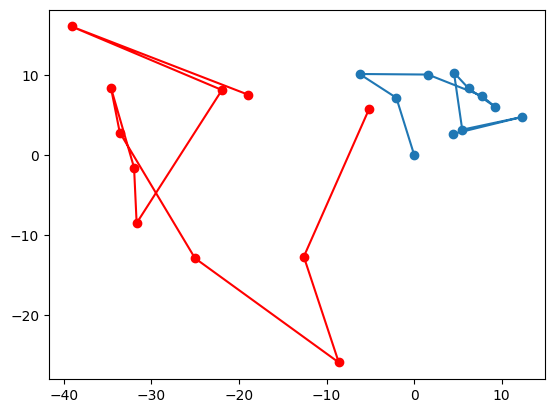

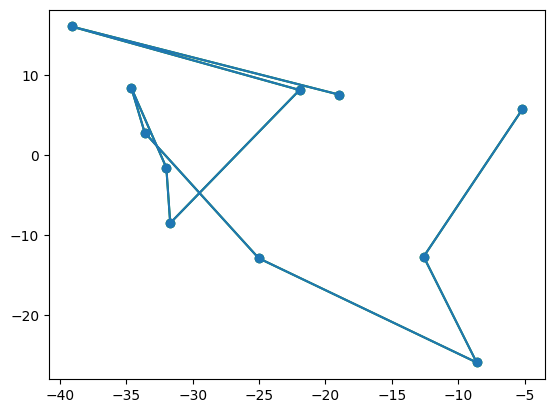

In [15]:
# Generate path
N_POINTS = 10
ORIGIN = np.zeros(2)
RADIUS = (1, 10)
path_x = generate_random_path(N_POINTS, ORIGIN, RADIUS)

# Generate new path
SCALE_RANGE = (0.1, 10)
ROTATION_RANGE = (-np.pi, np.pi)
TRANSLATION_RANGE = (-10, 10)
ADD_NOISE = False
NOISE_SIGMA = 0.5
path_y, c_gt, R_gt, t_gt = generate_random_scale_roto_translation(path_x, SCALE_RANGE, ROTATION_RANGE, TRANSLATION_RANGE, add_gaussian_noise=ADD_NOISE, sigma=NOISE_SIGMA)

# Solve
c, R, t = umeyama_kabsch(path_x, path_y)
reconstructed_path = apply_transformation(path_x, c, R, t)

print("### GT ###")
print("c:", c_gt)
print("R:", R_gt)
print("t:", t_gt)
print("loss:", loss(path_x, path_y, c=1, R=np.eye(2), t=np.zeros(2)))
print()
print("### Solution ###")
print("c:", c)
print("R:", R)
print("t:", t)
print("loss:", loss(path_x, path_y, c=c, R=R, t=t))

plt.plot(path_x[0, :], path_x[1, :], '-o')
plt.plot(path_y[0, :], path_y[1, :], 'r-o')
plt.show()
plt.plot(reconstructed_path[0, :], reconstructed_path[1, :], 'g-o')
plt.plot(path_y[0, :], path_y[1, :], '-o')
plt.show()